- EXPERIMENT 6
- OBJECTIVE : WAP to train and evaluate a Recurrent Neural Network using PyTorch Library to predict the next value in a sample time series dataset. 

- DESCRIPTION OF MODEL
- Model Type: Recurrent Neural Network (RNN)
  - Input Size: 4 (Open, High, Low, Volume)
  - Sequence Length: 25
  - Hidden Layer: 128
  - Output Layer: 1 (predicted closing price)
- Hyperparameters :
  - Epochs-70
  - Learning Rate-0.001
  - Optimizer-Adam
  - Loss Function-MSE (Mean Squared Error)
  - Time Step Window - 25
  - Random Seed - 42

PYTHON IMPLEMENTATION

Epoch 1/70 | Train MSE: 1804.49 | Train MAE: 33.29 | Train Accuracy: 63.80% | Train R²: -0.3598
Epoch 2/70 | Train MSE: 1071.96 | Train MAE: 26.97 | Train Accuracy: 70.66% | Train R²: 0.1922
Epoch 3/70 | Train MSE: 1396.05 | Train MAE: 31.51 | Train Accuracy: 65.72% | Train R²: -0.0520
Epoch 4/70 | Train MSE: 1587.89 | Train MAE: 34.11 | Train Accuracy: 62.90% | Train R²: -0.1966
Epoch 5/70 | Train MSE: 1337.64 | Train MAE: 31.15 | Train Accuracy: 66.12% | Train R²: -0.0080
Epoch 6/70 | Train MSE: 996.87 | Train MAE: 26.47 | Train Accuracy: 71.21% | Train R²: 0.2488
Epoch 7/70 | Train MSE: 773.01 | Train MAE: 23.10 | Train Accuracy: 74.87% | Train R²: 0.4175
Epoch 8/70 | Train MSE: 694.31 | Train MAE: 21.57 | Train Accuracy: 76.53% | Train R²: 0.4768
Epoch 9/70 | Train MSE: 705.75 | Train MAE: 21.41 | Train Accuracy: 76.71% | Train R²: 0.4682
Epoch 10/70 | Train MSE: 732.76 | Train MAE: 21.48 | Train Accuracy: 76.64% | Train R²: 0.4478
Epoch 11/70 | Train MSE: 717.92 | Train MAE: 21.11

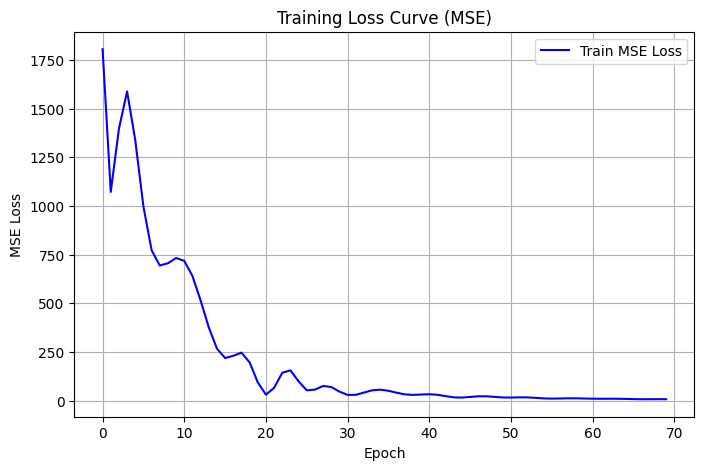

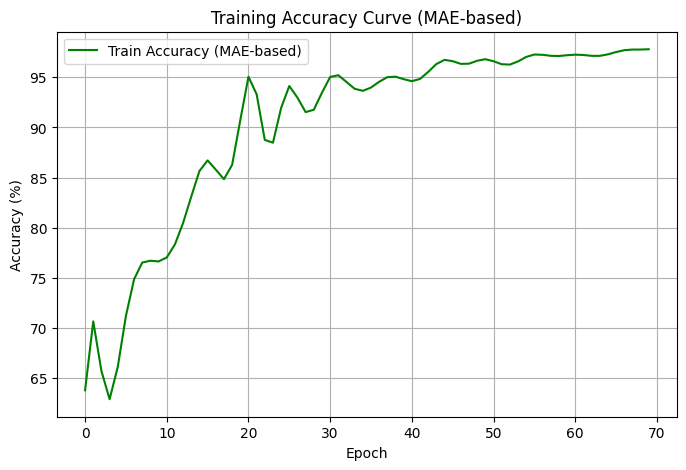


Test MSE: 68.15 | Test MAE: 6.37 | Test Accuracy: 96.97% | Test R²: 0.9609


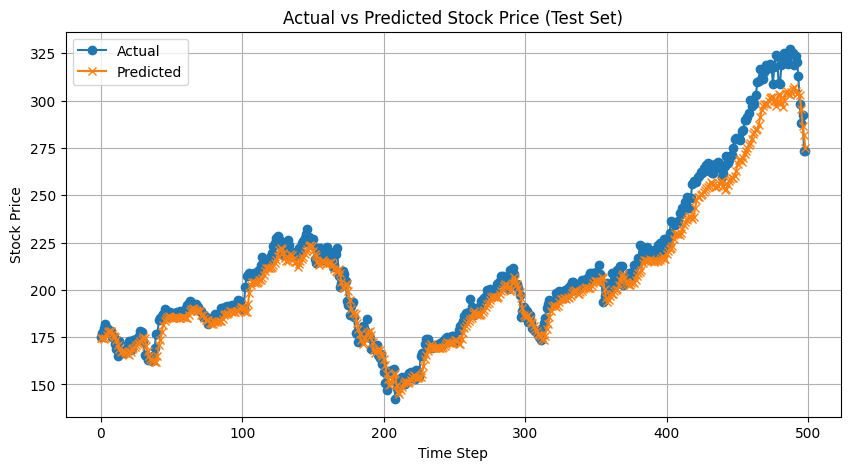


Predicted next stock price: $264.50


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Load and clean the dataset
file_path = "HistoricalQuotes[2].csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])

# Remove '$' and ',' from numeric columns
for col in df.columns:
    if col != 'Date':
        df[col] = df[col].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)
df.rename(columns={'Close/Last': 'Close'}, inplace=True)
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Features and target
features = ['Open', 'High', 'Low', 'Volume']
target_col = ['Close']
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[target_col])

# Create sequences
def create_sequences(X, y, time_step):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:i + time_step])
        y_seq.append(y[i + time_step])
    return np.array(X_seq), np.array(y_seq)

time_step = 25
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

X_seq = torch.tensor(X_seq, dtype=torch.float32)
y_seq = torch.tensor(y_seq, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])
input_size = len(features)
hidden_size = 128
output_size = 1
model = RNN(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, train_accuracy_scores, train_r2_scores = [], [], []
# Training loop
epochs = 70
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).detach().numpy()
        train_true = y_train.detach().numpy()

        train_pred_inv = scaler_y.inverse_transform(train_pred)
        train_true_inv = scaler_y.inverse_transform(train_true)

        train_mse = mean_squared_error(train_true_inv, train_pred_inv)
        train_mae = mean_absolute_error(train_true_inv, train_pred_inv)
        train_r2 = r2_score(train_true_inv, train_pred_inv)
        train_accuracy = 100 * (1 - train_mae / np.mean(train_true_inv))

        train_losses.append(train_mse)
        train_accuracy_scores.append(train_accuracy)
        train_r2_scores.append(train_r2)

        print(f"Epoch {epoch+1}/{epochs} | Train MSE: {train_mse:.2f} | Train MAE: {train_mae:.2f} | "
              f"Train Accuracy: {train_accuracy:.2f}% | Train R²: {train_r2:.4f}")
# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE Loss", color='blue')
plt.title("Training Loss Curve (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot training accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_scores, label="Train Accuracy (MAE-based)", color='green')
plt.title("Training Accuracy Curve (MAE-based)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()
# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).detach().numpy()
    y_test_true = y_test.detach().numpy()

    y_pred_test_inv = scaler_y.inverse_transform(y_pred_test)
    y_test_true_inv = scaler_y.inverse_transform(y_test_true)

    test_mse = mean_squared_error(y_test_true_inv, y_pred_test_inv)
    test_mae = mean_absolute_error(y_test_true_inv, y_pred_test_inv)
    test_r2 = r2_score(y_test_true_inv, y_pred_test_inv)
    test_accuracy = 100 * (1 - test_mae / np.mean(y_test_true_inv))

    print(f"\nTest MSE: {test_mse:.2f} | Test MAE: {test_mae:.2f} | "
          f"Test Accuracy: {test_accuracy:.2f}% | Test R²: {test_r2:.4f}")

    # Plot predictions
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_true_inv, label='Actual', marker='o')
    plt.plot(y_pred_test_inv, label='Predicted', marker='x')
    plt.title("Actual vs Predicted Stock Price (Test Set)")
    plt.xlabel("Time Step")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Predict next value
last_input = torch.tensor(X_scaled[-time_step:].reshape(1, time_step, len(features)), dtype=torch.float32)
with torch.no_grad():
    next_pred_scaled = model(last_input).item()
    next_price = scaler_y.inverse_transform([[next_pred_scaled]])[0, 0]
    print(f"\nPredicted next stock price: ${next_price:.2f}")

DESCRIPTION OF CODE

I have used Apple stock price dataset .
- 1. Dataset Preprocessing:
 - Loaded and cleaned historical stock data (from CSV)
 - Removes symbols  $ and , , parsed dates, sorted chronologically. Scales features to range [0,1] using MinMaxScaler (ensures better convergence).

- 2. Sequence Creation:
 - Features Used: ['Open', 'High', 'Low', 'Volume']
 - Target Variable: 'Close'
 - Creates sequences of 25 time steps for input to the RNN.
 - Each sequence is paired with the target closing price of the next day(26th) .

- 3. Model Construction:
 - Defined a custom RNN class with PyTorch’s built-in nn.RNN . 
 - input_size: 4, features given at each time step ( Open, High, Low, Volume).
 - hidden_size: 128 , neurons in the RNN's "memory" layer.
 - output_size: predicting 1 value,  "Close" price. 
 - Model takes stock data for the last 25 days.
 - The RNN reads that time sequence step by step and builds an understanding of the pattern(hidden state).
 - The final hidden state is given to a linear layer.
 - The linear layer predicts closing price for the next day.

- 4. Training Loop:
 - Model is trained on training data , backpropagation updates weights.
 - Metrics are stored and printed.
 - Calculated Train MSE, MAE, Accuracy, and R² after each epoch.
 - Accuracy defined via MAE: Accuracy = 100 - (MAE / mean_target) * 100 .

- 5. Evaluation:
 - Tested on unseen data (test set = last 20%) .
 - Inverted scaling to get real prices .
 - Plotted predicted vs actual stock prices and loss and accuracy curves .
 - Predicted the next stock price .

PERFORMANCE EVALUATION 
- Performance of model has been evaluated using mean_squared_error, mean_absolute_error, r2_score metrics .
- Accuracy has been calculated according to mae and loss has been calculated using mse.
- Loss and accuracy curves have been plotted.
- Actual and predicted values have been plotted .
- Train Accuracy: 97.80% , Test Accuracy: 96.97% , Train R²: 0.9940 , Test R²: 0.9609 .

MY COMMENTS
- Model has achieved Train Accuracy: 97.80% , Test Accuracy: 96.97%. Accuracy has been calculated using mae and r2 score as it is a regression problem .
- Accuracy improved by changing the number of hidden neurons from 64 to 128 .
- To keep accuracy same after re-running same python script , random seed has been set.
- To improve accuracy different hidden sizes, layers,time step and dropout can be used , also LSTM/GRU can be used instead of basic RNN .